In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

_path = os.getcwd()
while "running_dot" not in os.listdir(_path):
    _path = os.path.dirname(_path)
sys.path.append(_path)

In [203]:
from dotenv import load_dotenv

from running_dot.client.garmin import GarminClient

# load .env
load_dotenv()

# setup client
client = GarminClient()

## Create power dataset

In [251]:
from datetime import datetime

import pandas as pd

from running_dot.utils import get_power_indices, get_metric_index

POWER_DF_PATH = "data/power_df.csv"

if os.path.exists(POWER_DF_PATH):
    power_df = pd.read_csv(POWER_DF_PATH, index_col=0)
else:
    # load all activities with details
    activities = client.get_run_activities(total=-1)

    power_dataset = []
    for activity in activities[::-1]:
        activity.load_details(client)
        assert len(set([len(_m.value) for _m in activity.run_metrics if _m is not None])) == 1

        # get max time
        T = None
        for _m in activity.run_metrics:
            if T is not None:
                break
            if _m is None:
                continue
            T = len(_m.value)
        assert T is not None

        power_indices = get_power_indices(activity)
        speed_index = get_metric_index(activity, "speed")
        if not all(_v is not None for _v in power_indices.values()):
            # skip if all three values aren't present
            continue

        power_values = {k: activity.run_metrics[power_indices[k]].value for k in power_indices}
        speed_value = activity.run_metrics[speed_index].value
        # skip if stryd runs are all zeros
        if activity.run_metrics[power_indices["stryd"]].value.sum() == 0:
            continue

        for t in range(T):
            power_dataset.append({
                "activity_id": activity.activity_id,
                "speed": speed_value[t],
                **{k: power_values[k][t]
                for k in power_values}
            })

    # convert to df and postprocess
    power_df = pd.DataFrame(power_dataset)
    power_df["timestamp"] = power_df["timestamp"].map(lambda x: datetime.fromtimestamp(x/1000))
    power_df = power_df.set_index("timestamp")
    power_df.to_csv(POWER_DF_PATH)

## EDA

In [252]:
import matplotlib.pyplot as plt

In [253]:
# remove noise
power_df = power_df[power_df["stryd"] != 0]

In [254]:
power_df.head()

,activity_id,speed,stryd,garmin,runpowermodel
timestamp,,,,,
2024-03-16 06:48:16,14427060324,2.435,105.0,262.0,204.0
2024-03-16 06:48:20,14427060324,2.417,108.0,265.0,199.0
2024-03-16 06:48:24,14427060324,2.417,106.0,276.0,226.0
2024-03-16 06:48:28,14427060324,2.407,106.0,256.0,222.0
2024-03-16 06:48:32,14427060324,2.417,106.0,278.0,218.0


### Power Distribution

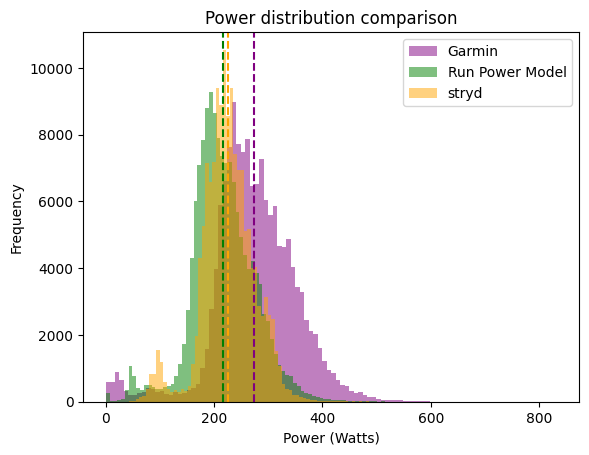

In [255]:
n_bins=100
power_df["garmin"].plot.hist(bins=n_bins, alpha=0.5, label="Garmin", color="purple")
plt.axvline(power_df["garmin"].mean(), linestyle="--", color="purple")
power_df["runpowermodel"].plot.hist(bins=n_bins, alpha=0.5, label="Run Power Model", color="green")
plt.axvline(power_df["runpowermodel"].mean(), linestyle="--", color="green")
power_df["stryd"].plot.hist(bins=n_bins, alpha=0.5, label="stryd", color="orange")
plt.axvline(power_df["stryd"].mean(), linestyle="--", color="orange")
plt.title("Power distribution comparison")
plt.xlabel("Power (Watts)")
plt.legend()
plt.show()

### Power measured group by pace